# Investigating OOD properties of the Ridgelet prior

The [Ridgelet prior](https://arxiv.org/abs/2010.08488) is a weight space prior $p(W)$ for an MLP network that can be constructed such that the corresponding function space prior $p(f)$ follows a target $\mathcal{GP}(m, K)$.

The construction of the Ridgelet prior, however, requires numerical approximation of integrals, one of which integrates over the whole input domain $\mathcal{X}$, which for us contains all in- and out-of-distribution data. This integral is approximated by choosing a subdomain $[-S,S]^d$. We hypothesize, that the $\mathcal{GP}$ properties can only be reproduced within this subdomain!

In [1]:
#import gpytorch
from argparse import Namespace
from datetime import datetime
from hypnettorch.mnets import MLP
from hypnettorch.utils.sim_utils import setup_environment
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared
import sys
from time import time
import torch

# Pretend that notebook is located in base directory of this repo.
curr_dir = os.path.basename(os.path.abspath(os.curdir))
base_dir = os.path.abspath('../..')
if curr_dir == 'finite_width' and base_dir != sys.path[0]:
    sys.path.insert(0, base_dir)

from data.regression_utils import generate_1d_dataset
from finite_width import ridgelet_prior as rp
from utils.plotting import plot_predictive_distributions_1dr


from IPython.display import display, Markdown, Latex
#display(Markdown('*some markdown* $\phi$'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Create output directory and other helpers.
config = Namespace()
config.out_dir = './out/ridgelet_prior/run_' + \
    datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
config.loglevel_info = False
config.random_seed = 42
config.use_cuda = False # CPU usually faster for simple problems.
config.deterministic_run = True
# Delete file from previous tutorial session:
if os.path.exists(config.out_dir):
    shutil.rmtree(config.out_dir)
device, writer, logger = setup_environment(config, logger_name='ridgelet_prior_logger')

Created output folder ./out/ridgelet_prior/run_2021-10-04_10-17-05.
10/04/2021 10:17:05 AM - INFO - Using cuda: False


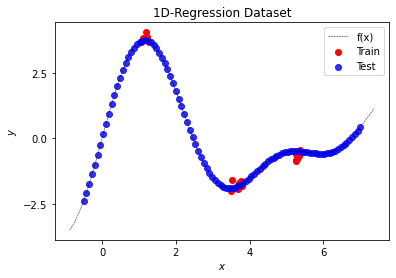

In [2]:
data = generate_1d_dataset(task_id=6)
data.plot_dataset()

X_train_np = data.get_train_inputs()
Y_train_np = data.get_train_outputs()
X_test_np = data.get_test_inputs()

# Translate grid to PyTorch tensor.
X_train = torch.from_numpy(X_train_np.astype(np.float32)).to(device)
Y_train = torch.from_numpy(Y_train_np.astype(np.float32)).to(device)
X_test = torch.from_numpy(X_test_np.astype(np.float32)).to(device)

likelihood_var = .2 # Ground-truth

In [14]:
pd_plot_kwargs = {
    'sigma_ll': None, #likelihood_var,
    'show_title': False,
    'xticks': [0, 3, 6],
    'yticks': [-3, 0, 3],
    'xlim': [-.5, 6.5],
    'ylim': [-4, 4],
    'show_legend': True,
    'out_dir': config.out_dir,
    'ts': 30,
    'lw': 15,
    'ms': 5,
    'figsize': (12, 7),
    'show_plot': True
}

# Setup Ridgelet prior

Note, that we need to specify an $\mathcal{X}$ domain in which the GP prior is matched, and that the current implementation requires this domain to be a hypercube centered at zero (even though, that assumption could be easily changed.

In [4]:
d = 1
S = 6
D = 200
N = 3000
sigma2_w = (3.)**2
sigma2_b = (12.)**2
non_linearity = 'tanh'

X_rp_grid = rp.regular_grid(cube_size=S, res_per_dim=D, grid_dim=d,
                            device=device)

X_rp_grid_ood = rp.regular_grid(cube_size=4*S, res_per_dim=4*D, grid_dim=d,
                                device=device)

net = MLP(n_in=d, n_out=1, hidden_layers=(N,),
          activation_fn=torch.nn.ReLU() if non_linearity == 'relu' else \
                        torch.nn.Tanh())

trgt_GP_mean = torch.zeros(X_rp_grid.shape[0]).to(device)

Creating an MLP with 9001 weights.


In [5]:
def get_ridgelet_samples(trgt_GP_cov, n_samples=100):
    if not isinstance(trgt_GP_cov, torch.Tensor):
        trgt_GP_cov = torch.from_numpy(trgt_GP_cov).\
            type(torch.FloatTensor).to(device)

    samples = []
    while len(samples) < n_samples:
        try:
            sample = rp.ridgelet_prior_sample(net, phi_name=non_linearity,
                cube_size=S, grid_points=X_rp_grid, gp_mean=trgt_GP_mean,
                gp_cov=trgt_GP_cov, sigma2_w=sigma2_w, sigma2_b=sigma2_b,
                return_dist=False)
            samples.append(sample)
        except:
            print('Sampling failed')

    return samples

def samples_to_functions(X, W_samples):
    """Translate weight samples to samples in function space."""
    preds = []
    for W in W_samples:
        p = net.forward(X, weights=W)
        preds.append(p.squeeze())
    preds = torch.stack(preds)
    
    preds_mean = preds.mean(dim=0)
    preds_std = preds.std(dim=0)

    return preds, preds_mean, preds_std

In [6]:
gp_priors_struct = [
    {'type': 'rbf',
     'kernel_params': {'length_scale': 1., 'length_scale_bounds': 'fixed'}},
    #{'type': 'ess',
    # 'kernel_params': {'length_scale': 1.0, 'length_scale_bounds': 'fixed',
    #                   'periodicity': 1, 'periodicity_bounds': 'fixed'}},
    #{'type': 'ess',
    # 'kernel_params': {'length_scale': 1.0, 'length_scale_bounds': 'fixed',
    #                   'periodicity': 3, 'periodicity_bounds': 'fixed'}},
    #{'type': 'ess',
    # 'kernel_params': {'length_scale': 1.0, 'length_scale_bounds': 'fixed',
    #                   'periodicity': 5, 'periodicity_bounds': 'fixed'}},
    #{'type': 'ess',
    # 'kernel_params': {'length_scale': 1.0, 'length_scale_bounds': 'fixed',
    #                   'periodicity': 7, 'periodicity_bounds': 'fixed'}},
]

In [7]:
for pdict in gp_priors_struct:
    if pdict['type'] == 'rbf':
        kernel = RBF(**pdict['kernel_params'])
    elif pdict['type'] == 'ess':
        kernel = ExpSineSquared(**pdict['kernel_params'])
    pdict['kernel'] = kernel
    
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=likelihood_var, 
                                   random_state=42)
    pdict['gpr_instance'] = gpr
    
    ### Get corresponding Ridgelet samples.
    K_rp_grid = kernel(X_rp_grid)
    weights_samples_rp = get_ridgelet_samples(K_rp_grid, n_samples=100)
    pdict['rp_samples'] = weights_samples_rp
    
    if pdict['type'] == 'rbf':
        ls = pdict['kernel_params']['length_scale']
        pdict['gp_plot_fn_ind_prior_samples'] = 'gp_prior_samples_rbf_%f' % (ls)
        pdict['gp_plot_fn_ood_prior_samples'] = 'gp_prior_samples_ood_rbf_%f' % (ls)
        pdict['rp_plot_fn_ind_prior_samples'] = 'rp_prior_samples_rbf_%f' % (ls)
        pdict['rp_plot_fn_ood_prior_samples'] = 'rp_prior_samples_ood_rbf_%f' % (ls)
        pdict['gp_plot_fn_post_samples'] = 'gp_post_samples_rbf_%f' % (ls)
    elif pdict['type'] == 'ess':
        ls = pdict['kernel_params']['length_scale']
        p = pdict['kernel_params']['periodicity']
        pdict['gp_plot_fn_ind_prior_samples'] = 'gp_prior_samples_ess_%f_%f' % (ls, p)
        pdict['gp_plot_fn_ood_prior_samples'] = 'gp_prior_samples_ood_ess_%f_%f' % (ls, p)
        pdict['rp_plot_fn_ind_prior_samples'] = 'rp_prior_samples_ess_%f_%f' % (ls, p)
        pdict['rp_plot_fn_ood_prior_samples'] = 'rp_prior_samples_ood_ess_%f_%f' % (ls, p)
        pdict['gp_plot_fn_post_samples'] = 'gp_post_samples_ess_%f_%f' % (ls, p)

/home/christian/workspace/uncertainty-based-ood/finite_width/ridgelet_prior.py:533: UserWarning: Kenel matrix inversion required diagonal noise adaptation of scale 0.000012.
  warn('Kenel matrix inversion required diagonal noise adaptation ' +


## RBF Prior and corresponding Ridgelet induced prior.

Here, we show in-distribution plots, i.e., plots of the function-space prior that are within the $\mathcal{X}$ domain in which the Ridgelet prior is matched to the GP, as well as extended plots that indicate the behavior on OOD data.

Type **rbf**, specs: {'length_scale': 1.0, 'length_scale_bounds': 'fixed'}

Behavior inside $\mathcal{X}$

Behavior on OOD

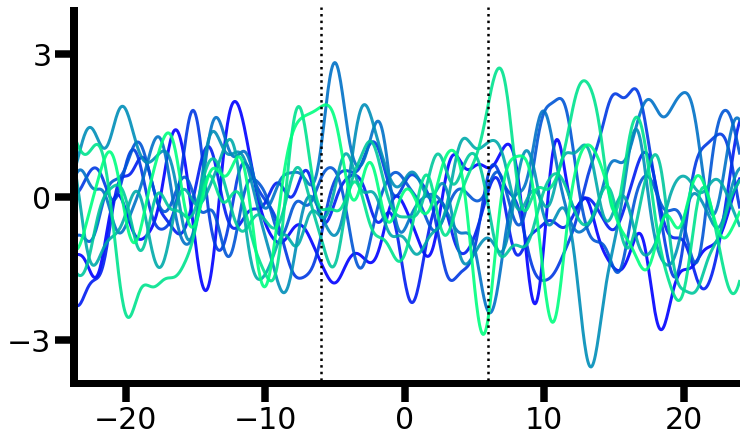

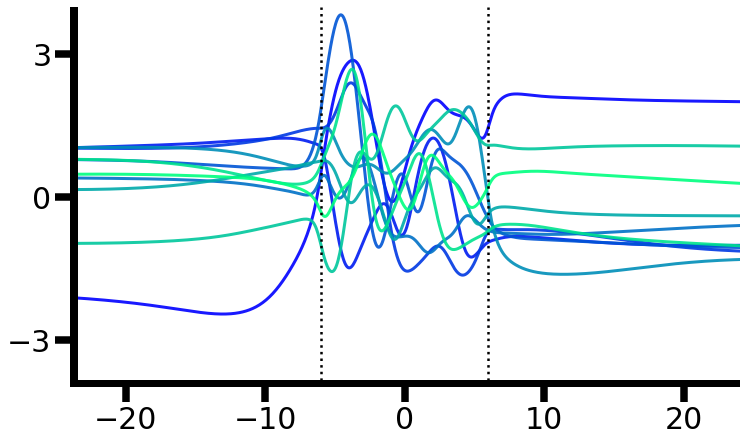

In [15]:
for pdict in gp_priors_struct:
    display(Markdown('Type **%s**, specs: %s' % \
                     (pdict['type'], str(pdict['kernel_params']))))
                     
    display(Markdown('Behavior inside $\mathcal{X}$'))
            
    kernel = pdict['kernel']
    gpr = pdict['gpr_instance']

    gp_mean, gp_std = gpr.predict(X_rp_grid, return_std=True)
    gp_samples = gpr.sample_y(X_rp_grid, n_samples=10)

    pd_plot_kwargs_tmp = dict(pd_plot_kwargs)
    #pd_plot_kwargs_tmp['yticks'] = None
    pd_plot_kwargs_tmp['xticks'] = [-4, 0, 4]
    pd_plot_kwargs_tmp['xlim'] = [-6, 6]
    pd_plot_kwargs_tmp['show_legend'] = False
    
    '''
    plot_predictive_distributions_1dr(None, X_rp_grid, pd_samples=None,
        pd_mean=gp_mean, pd_std=gp_std,
        title='GP prior over functions',
        filename=None, **pd_plot_kwargs_tmp)

    plot_predictive_distributions_1dr(None, X_rp_grid, pd_samples=gp_samples,
        pd_mean=None, pd_std=None,
        title='GP prior samples',
        filename=pdict['gp_plot_fn_ind_prior_samples'], **pd_plot_kwargs_tmp)
    '''
    
    W_rp = pdict['rp_samples']
    rp_samples, rp_mean, rp_std = samples_to_functions(X_rp_grid, W_rp)
    
    '''
    plot_predictive_distributions_1dr(None, X_rp_grid, pd_samples=None,
        pd_mean=rp_mean, pd_std=rp_std,
        title='Ridglet prior over functions',
        filename=None, **pd_plot_kwargs_tmp)

    plot_predictive_distributions_1dr(None, X_rp_grid, pd_samples=rp_samples[:10,:].T,
        pd_mean=None, pd_std=None,
        title='Ridglet prior samples',
        filename=pdict['rp_plot_fn_ind_prior_samples'], **pd_plot_kwargs_tmp)
    '''
    
    display(Markdown('Behavior on OOD'))
    
    pd_plot_kwargs_tmp = dict(pd_plot_kwargs)
    pd_plot_kwargs_tmp['xticks'] = [-20, -10, 0, 10, 20]
    pd_plot_kwargs_tmp['xlim'] = [-24, 24]
    pd_plot_kwargs_tmp['vlines'] = [-6, 6]
    pd_plot_kwargs_tmp['show_legend'] = False
    
    gp_samples_ood = gpr.sample_y(X_rp_grid_ood.numpy(), n_samples=10)

    plot_predictive_distributions_1dr(None, X_rp_grid_ood, pd_samples=gp_samples_ood,
        pd_mean=None, pd_std=None,
        title='GP prior samples',
        filename=pdict['gp_plot_fn_ood_prior_samples'], **pd_plot_kwargs_tmp)
    
    rp_samples_ood, rp_mean_ood, rp_std_ood = \
        samples_to_functions(X_rp_grid_ood, W_rp)

    plot_predictive_distributions_1dr(None, X_rp_grid_ood,
        pd_samples=rp_samples_ood[:10,:].T, pd_mean=None, pd_std=None,
        title='Ridglet prior samples',
        filename=pdict['rp_plot_fn_ood_prior_samples'], **pd_plot_kwargs_tmp)

## Gaussian Process Regression

Some posterior plots.

Type **rbf**, specs: {'length_scale': 1.0, 'length_scale_bounds': 'fixed'}

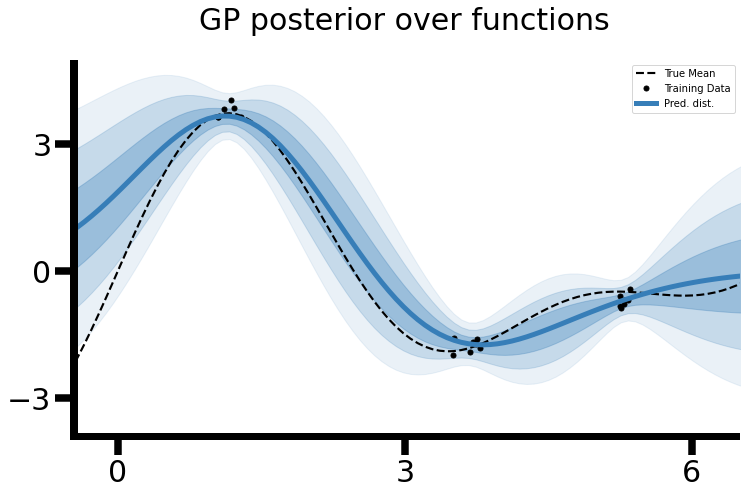

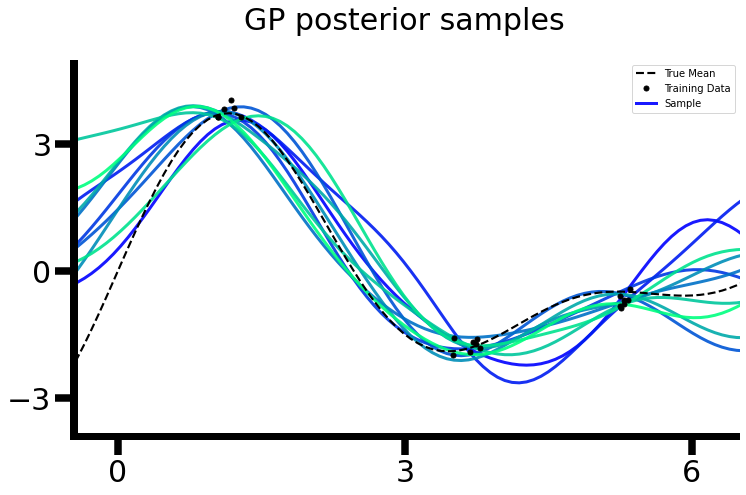

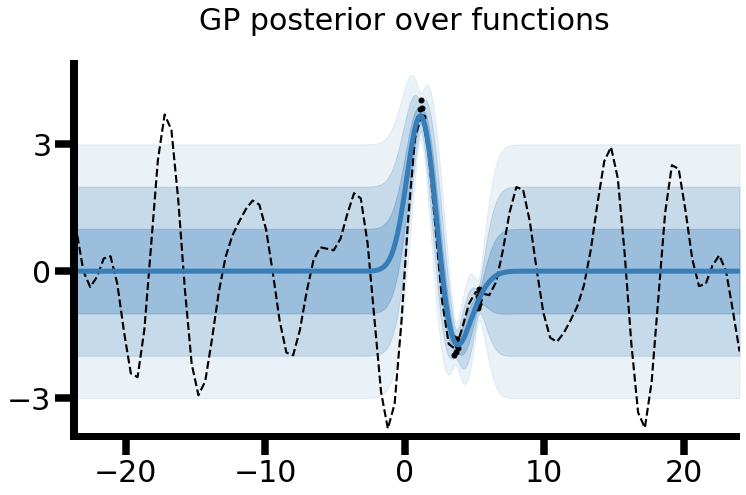

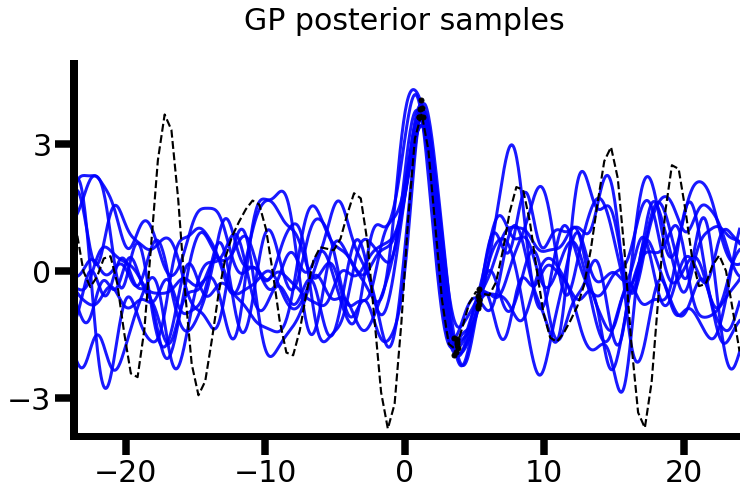

Type **ess**, specs: {'length_scale': 1.0, 'length_scale_bounds': 'fixed', 'periodicity': 7, 'periodicity_bounds': 'fixed'}

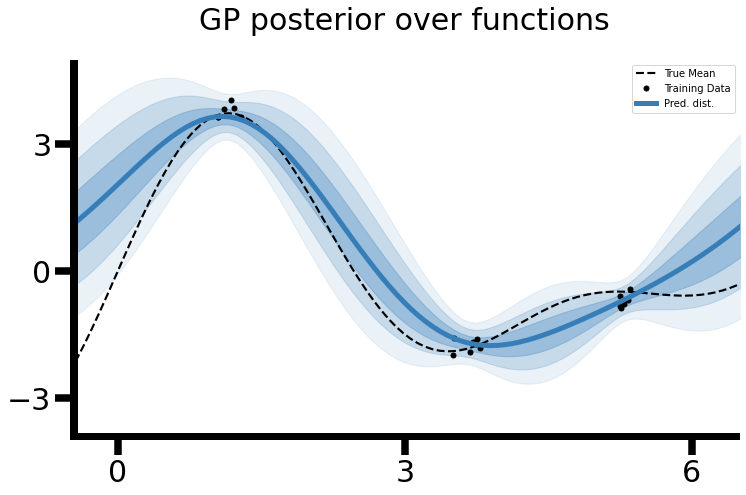

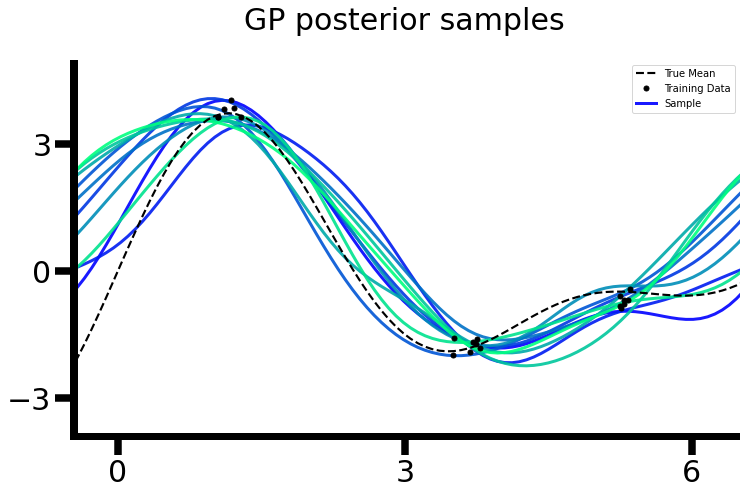

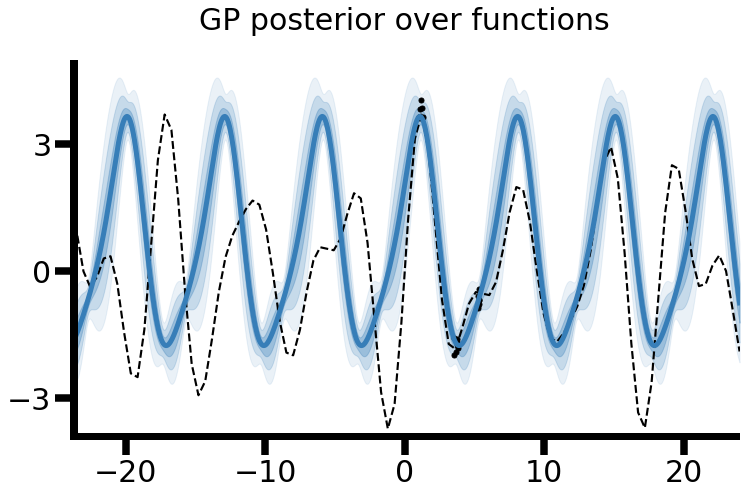

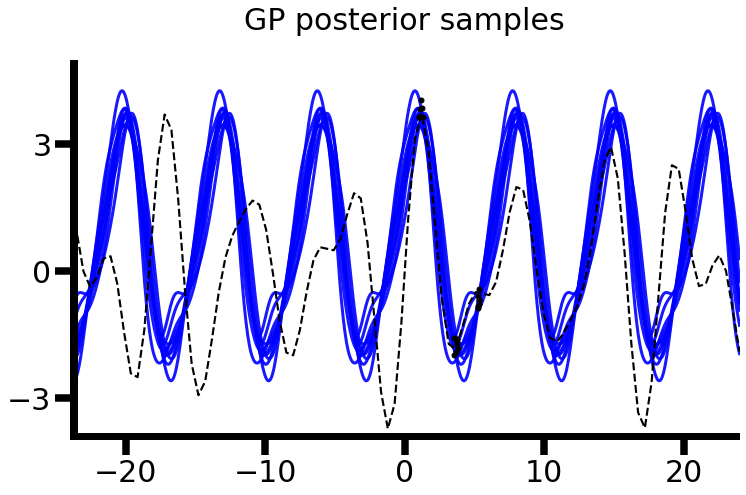

In [9]:
for pdict in gp_priors_struct:
    display(Markdown('Type **%s**, specs: %s' % \
                     (pdict['type'], str(pdict['kernel_params']))))
            
    kernel = pdict['kernel']
    gpr = pdict['gpr_instance']

    #K = kernel(X_train_np)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=likelihood_var, 
                                   random_state=42).fit(X_train_np, Y_train_np)

    #rbf_train_mean, rbf_train_std = gpr.predict(X_train_np, return_std=True)
    grid_mean, grid_std = gpr.predict(X_test_np, return_std=True)
    grid_samples = gpr.sample_y(X_test_np, n_samples=10).squeeze(1)

    plot_predictive_distributions_1dr(data, X_test, pd_samples=None,
        pd_mean=grid_mean, pd_std=grid_std,
        title='GP posterior over functions',
        filename=None, **pd_plot_kwargs)

    plot_predictive_distributions_1dr(data, X_test, pd_samples=grid_samples,
        pd_mean=None, pd_std=None,
        title='GP posterior samples',
        filename=pdict['gp_plot_fn_post_samples'], **pd_plot_kwargs)
    
    pd_plot_kwargs_tmp = dict(pd_plot_kwargs)
    pd_plot_kwargs_tmp['xticks'] = [-20, -10, 0, 10, 20]
    pd_plot_kwargs_tmp['xlim'] = [-24, 24]
    pd_plot_kwargs_tmp['show_legend'] = False
    
    grid_mean_ood, grid_std_ood = gpr.predict(X_rp_grid_ood.numpy(),
                                              return_std=True)
    gp_samples_ood = gpr.sample_y(X_rp_grid_ood.numpy(), n_samples=10)

    plot_predictive_distributions_1dr(data, X_rp_grid_ood, pd_samples=None,
        pd_mean=grid_mean_ood, pd_std=grid_std_ood,
        title='GP posterior over functions',
        filename=None, **pd_plot_kwargs_tmp)
    
    plot_predictive_distributions_1dr(data, X_rp_grid_ood, pd_samples=gp_samples_ood,
        pd_mean=None, pd_std=None,
        title='GP posterior samples',
        filename=None, **pd_plot_kwargs_tmp)